[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Dataset shape: (6000, 2)

First 5 rows:
                                               review sentiment
0  I was looking forward to seeing Bruce Willis i...  negative
1  Bugs Bunny accidentally ends up at the South P...  negative
2  I find it difficult to comprehend what makes v...  negative
3  It's been said several times - not least by me...  negative
4  New rule. Nobody is allowed to make any more Z...  negative

Class Distribution:
 sentiment
negative    3000
positive    3000
Name: count, dtype: int64

Review Length Stats:
 count    5998.000000
mean      229.854952
std       171.220731
min        12.000000
25%       126.000000
50%       170.000000
75%       282.000000
max      1522.000000
Name: review_length, dtype: float64


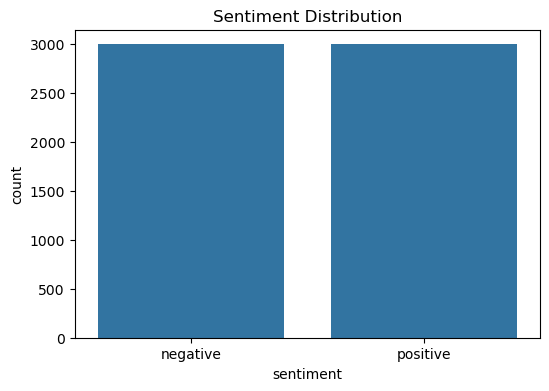

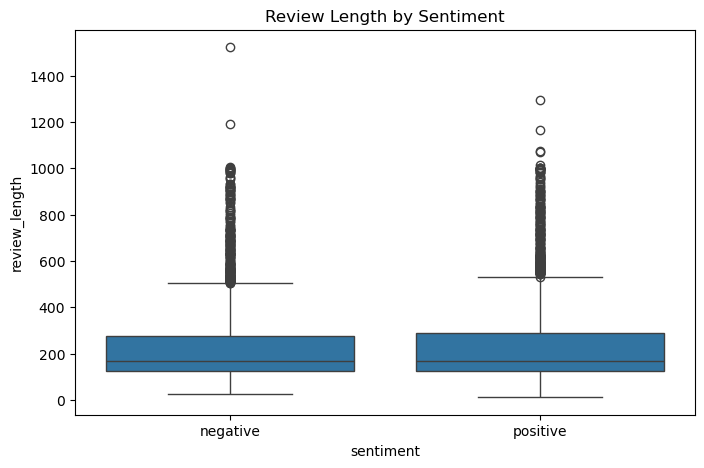


==== Logistic Regression Results ====
Accuracy: 0.8617
F1-score: 0.8655
ROC-AUC: 0.9369


ValueError: X has 2001 features, but MLPClassifier is expecting 3001 features as input.

In [3]:
# =========================
# 1. Import Libraries
# =========================
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, f1_score
from scipy.sparse import hstack
import joblib
import json

nltk.download('stopwords')
stop = set(stopwords.words('english'))

# =========================
# 2. Load Dataset & EDA
# =========================
df = pd.read_csv(r"data/IMDB_small.csv")

# Basic info
print("Dataset shape:", df.shape)
print("\nFirst 5 rows:\n", df.head())
print("\nClass Distribution:\n", df['sentiment'].value_counts())

# Clean duplicates & missing
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)

# Review length
df['review_length'] = df['review'].apply(lambda x: len(str(x).split()))
print("\nReview Length Stats:\n", df['review_length'].describe())

# Visualize sentiment distribution
plt.figure(figsize=(6,4))
sns.countplot(x='sentiment', data=df)
plt.title("Sentiment Distribution")
plt.show()

# Boxplot: review length by sentiment
plt.figure(figsize=(8,5))
sns.boxplot(x='sentiment', y='review_length', data=df)
plt.title("Review Length by Sentiment")
plt.show()

# =========================
# 3. Preprocessing
# =========================
df['sentiment_label'] = df['sentiment'].map({'positive':1, 'negative':0})

def clean_text(text):
    text = re.sub('<.*?>', '', str(text))
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = text.lower()
    return ' '.join([w for w in text.split() if w not in stop])

df['clean_review'] = df['review'].apply(clean_text)

vectorizer = TfidfVectorizer(max_features=2000)
X_text = vectorizer.fit_transform(df['clean_review'])
X_extra = np.array(df['review_length']).reshape(-1,1)
X = hstack([X_text, X_extra])
y = df['sentiment_label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# =========================
# 4. Load Models
# =========================
lr_model = joblib.load(r"data/lr_model.pkl")
mlp_model = joblib.load(r"data/mlp_model_improved.pkl")

# =========================
# 5. Evaluate Both Models
# =========================
def evaluate_model(model, X_test, y_test, name):
    y_pred = model.predict(X_test)
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:,1]
    else:
        y_prob = y_pred
    
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    print(f"\n==== {name} Results ====")
    print("Accuracy:", round(acc,4))
    print("F1-score:", round(f1,4))
    print("ROC-AUC:", round(roc_auc,4))
    return acc, f1, roc_auc

lr_acc, lr_f1, lr_roc = evaluate_model(lr_model, X_test, y_test, "Logistic Regression")
mlp_acc, mlp_f1, mlp_roc = evaluate_model(mlp_model, X_test, y_test, "MLPClassifier")

# Compare visually
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'MLPClassifier'],
    'Accuracy': [lr_acc, mlp_acc],
    'F1-score': [lr_f1, mlp_f1],
    'ROC-AUC': [lr_roc, mlp_roc]
})

plt.figure(figsize=(7,5))
sns.barplot(data=results.melt(id_vars='Model'), x='Model', y='value', hue='variable')
plt.title("Model Comparison")
plt.ylabel("Score")
plt.show()

print("\nModel Comparison Table:\n", results)

# =========================
# 6. Hyperparameter Tuning (for the better model)
# =========================
best_model_name = "MLPClassifier" if mlp_acc > lr_acc else "Logistic Regression"
print(f"\nBetter performing model: {best_model_name}")

if best_model_name == "MLPClassifier":
    param_grid = {
        'hidden_layer_sizes': [(64,32), (128,64), (256,128)],
        'activation': ['relu', 'tanh'],
        'solver': ['adam'],
        'alpha': [0.0001, 0.001],
        'learning_rate': ['constant', 'adaptive']
    }
    base_model = MLPClassifier(max_iter=30, random_state=42)
else:
    param_grid = {
        'C': [0.1, 1, 10],
        'penalty': ['l2'],
        'solver': ['liblinear', 'lbfgs']
    }
    base_model = LogisticRegression(max_iter=500, random_state=42)

grid = GridSearchCV(base_model, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

print("\nBest Parameters:", grid.best_params_)
print("Best Cross-Validation Accuracy:", round(grid.best_score_,4))

# Evaluate tuned model
best_model = grid.best_estimator_
y_pred_best = best_model.predict(X_test)
acc_best = accuracy_score(y_test, y_pred_best)
print("\nFinal Tuned Model Accuracy:", round(acc_best,4))

# =========================
# 7. Save Tuned Model
# =========================
joblib.dump(best_model, r"data/best_model.pkl")
print("\n✅ Final tuned model saved as 'data/best_model.pkl'")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Dataset shape: (6000, 2)

First 5 rows:
                                               review sentiment
0  I was looking forward to seeing Bruce Willis i...  negative
1  Bugs Bunny accidentally ends up at the South P...  negative
2  I find it difficult to comprehend what makes v...  negative
3  It's been said several times - not least by me...  negative
4  New rule. Nobody is allowed to make any more Z...  negative

After Cleaning:  (5998, 2)

Review Length Stats:
 count    5998.000000
mean      229.854952
std       171.220731
min        12.000000
25%       126.000000
50%       170.000000
75%       282.000000
max      1522.000000
Name: review_length, dtype: float64


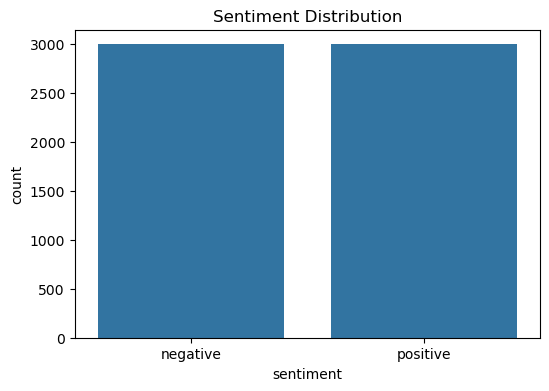

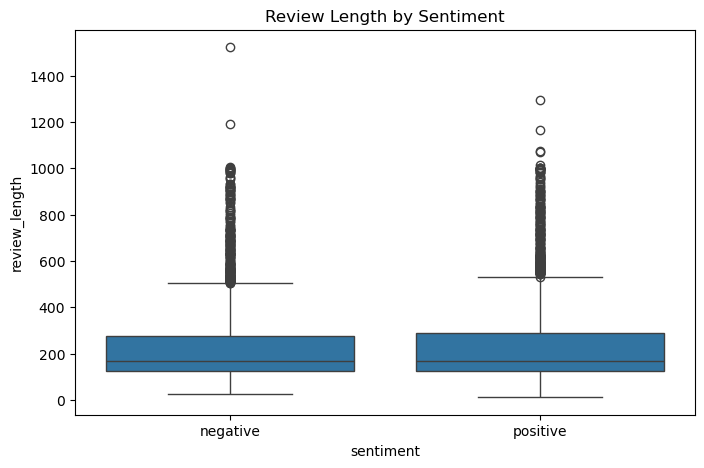


==== Logistic Regression Results ====
Accuracy: 0.8617
F1-score: 0.8655
ROC-AUC: 0.9369

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.83      0.86       600
           1       0.84      0.89      0.87       600

    accuracy                           0.86      1200
   macro avg       0.86      0.86      0.86      1200
weighted avg       0.86      0.86      0.86      1200



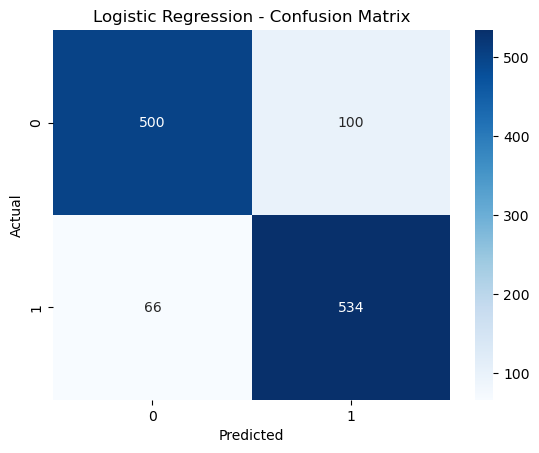

ValueError: X has 2001 features, but MLPClassifier is expecting 3001 features as input.

In [5]:
# =========================
# 1. Import Libraries
# =========================
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, classification_report,
    confusion_matrix, roc_curve
)
from scipy.sparse import hstack
import joblib

# =========================
# 2. Setup & Data Loading
# =========================
nltk.download('stopwords')
stop = set(stopwords.words('english'))

df = pd.read_csv(r"data/IMDB_small.csv")
print("Dataset shape:", df.shape)
print("\nFirst 5 rows:\n", df.head())

# =========================
# 3. Data Cleaning & EDA
# =========================
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)
print("\nAfter Cleaning: ", df.shape)

# Review length feature
df['review_length'] = df['review'].apply(lambda x: len(str(x).split()))
print("\nReview Length Stats:\n", df['review_length'].describe())

# Visualizations
plt.figure(figsize=(6,4))
sns.countplot(x='sentiment', data=df)
plt.title("Sentiment Distribution")
plt.show()

plt.figure(figsize=(8,5))
sns.boxplot(x='sentiment', y='review_length', data=df)
plt.title("Review Length by Sentiment")
plt.show()

# =========================
# 4. Text Preprocessing
# =========================
df['sentiment_label'] = df['sentiment'].map({'positive':1, 'negative':0})

def clean_text(text):
    text = re.sub('<.*?>', '', str(text))
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = text.lower()
    return ' '.join([w for w in text.split() if w not in stop])

df['clean_review'] = df['review'].apply(clean_text)

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=2000)
X_text = vectorizer.fit_transform(df['clean_review'])
X_extra = np.array(df['review_length']).reshape(-1,1)
X = hstack([X_text, X_extra])
y = df['sentiment_label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# =========================
# 5. Load Models
# =========================
lr_model = joblib.load(r"data/lr_model.pkl")
mlp_model = joblib.load(r"data/mlp_model_improved.pkl")

# =========================
# 6. Evaluation Function
# =========================
def evaluate_model(model, X_test, y_test, name):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1] if hasattr(model, "predict_proba") else y_pred

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    
    print(f"\n==== {name} Results ====")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    
    return acc, f1, roc_auc, y_prob

# =========================
# 7. Compare Models
# =========================
lr_acc, lr_f1, lr_roc, lr_prob = evaluate_model(lr_model, X_test, y_test, "Logistic Regression")
mlp_acc, mlp_f1, mlp_roc, mlp_prob = evaluate_model(mlp_model, X_test, y_test, "Improved MLPClassifier")

# Bar comparison
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Improved MLPClassifier'],
    'Accuracy': [lr_acc, mlp_acc],
    'F1-score': [lr_f1, mlp_f1],
    'ROC-AUC': [lr_roc, mlp_roc]
})
plt.figure(figsize=(7,5))
sns.barplot(data=results.melt(id_vars='Model'), x='Model', y='value', hue='variable')
plt.title("Model Comparison")
plt.ylabel("Score")
plt.show()

print("\nModel Comparison Table:\n", results)

# ROC curve comparison
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_prob)
fpr_mlp, tpr_mlp, _ = roc_curve(y_test, mlp_prob)
plt.figure(figsize=(7,5))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC={lr_roc:.3f})')
plt.plot(fpr_mlp, tpr_mlp, label=f'MLPClassifier (AUC={mlp_roc:.3f})')
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()

# =========================
# 8. Hyperparameter Tuning (MLP only)
# =========================
print("\n🔧 Running Hyperparameter Tuning for MLPClassifier...")
param_grid = {
    'hidden_layer_sizes': [(64,32), (128,64), (256,128)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.001],
    'learning_rate': ['constant', 'adaptive']
}

mlp_tune = MLPClassifier(max_iter=30, random_state=42)
grid = GridSearchCV(mlp_tune, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

print("\nBest Parameters:", grid.best_params_)
print("Best Cross-Validation Accuracy:", round(grid.best_score_,4))

best_mlp = grid.best_estimator_
y_pred_best = best_mlp.predict(X_test)
acc_best = accuracy_score(y_test, y_pred_best)
f1_best = f1_score(y_test, y_pred_best)
roc_best = roc_auc_score(y_test, best_mlp.predict_proba(X_test)[:,1])
print("\nFinal Tuned MLP Accuracy:", round(acc_best,4))
print("Final Tuned MLP F1-score:", round(f1_best,4))
print("Final Tuned MLP ROC-AUC:", round(roc_best,4))

# =========================
# 9. Save Final Model
# =========================
joblib.dump(best_mlp, r"data/best_model.pkl")
print("\n✅ Final tuned MLP model saved as 'data/best_model.pkl'")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Dataset shape: (6000, 2)

Class Distribution:
 sentiment
negative    3000
positive    3000
Name: count, dtype: int64


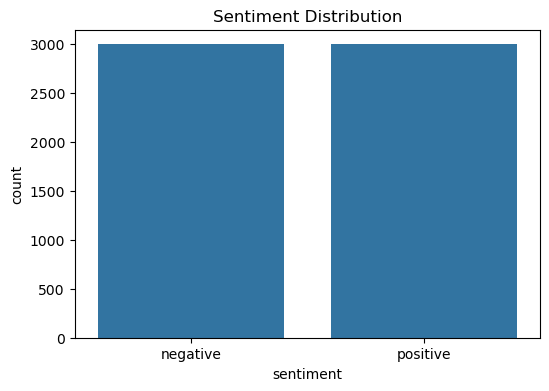

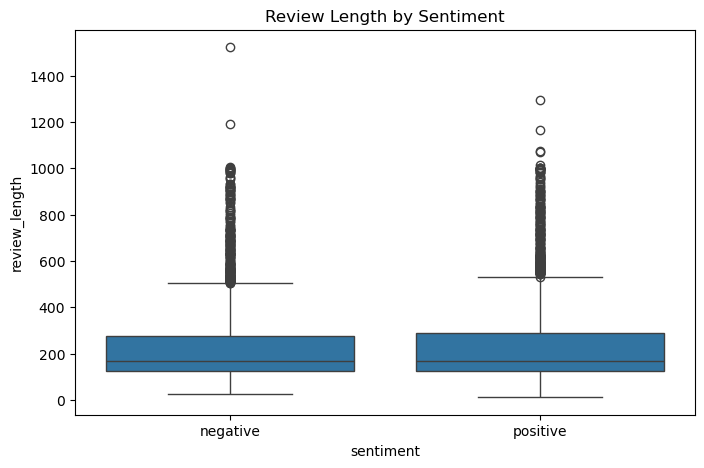

✅ Found existing vectorizer — loading it.


ValueError: X has 3001 features, but LogisticRegression is expecting 2001 features as input.

In [7]:
# =========================
# 1. Import Libraries
# =========================
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, classification_report,
    confusion_matrix, roc_curve
)
from scipy.sparse import hstack
import joblib
import os

nltk.download('stopwords')
stop = set(stopwords.words('english'))

# =========================
# 2. Load Dataset
# =========================
df = pd.read_csv(r"data/IMDB_small.csv")

print("Dataset shape:", df.shape)
print("\nClass Distribution:\n", df['sentiment'].value_counts())

# Remove duplicates and nulls
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)

# Add review length feature
df['review_length'] = df['review'].apply(lambda x: len(str(x).split()))

# =========================
# 3. EDA (Visuals)
# =========================
plt.figure(figsize=(6,4))
sns.countplot(x='sentiment', data=df)
plt.title("Sentiment Distribution")
plt.show()

plt.figure(figsize=(8,5))
sns.boxplot(x='sentiment', y='review_length', data=df)
plt.title("Review Length by Sentiment")
plt.show()

# =========================
# 4. Preprocessing
# =========================
df['sentiment_label'] = df['sentiment'].map({'positive': 1, 'negative': 0})

def clean_text(text):
    text = re.sub('<.*?>', '', str(text))
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = text.lower()
    return ' '.join([w for w in text.split() if w not in stop])

df['clean_review'] = df['review'].apply(clean_text)

# =========================
# 5. Load or Create Vectorizer
# =========================
if os.path.exists("data/vectorizer.pkl"):
    print("✅ Found existing vectorizer — loading it.")
    vectorizer = joblib.load("data/vectorizer.pkl")
    X_text = vectorizer.transform(df['clean_review'])
else:
    print("⚙️ No vectorizer found — creating new TF-IDF vectorizer.")
    vectorizer = TfidfVectorizer(max_features=2000)
    X_text = vectorizer.fit_transform(df['clean_review'])
    joblib.dump(vectorizer, "data/vectorizer.pkl")
    print("✅ Saved new vectorizer as data/vectorizer.pkl")

# Combine text and numeric features
X_extra = np.array(df['review_length']).reshape(-1, 1)
X = hstack([X_text, X_extra])
y = df['sentiment_label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# =========================
# 6. Load Models
# =========================
lr_model = joblib.load("data/lr_model.pkl")
mlp_model = joblib.load("data/mlp_model_improved.pkl")

# =========================
# 7. Evaluation Function
# =========================
def evaluate_model(model, X_test, y_test, name):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else y_pred

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)

    print(f"\n==== {name} ====")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")

    return acc, f1, roc_auc, y_prob

# =========================
# 8. Evaluate Both Models
# =========================
lr_acc, lr_f1, lr_roc, lr_prob = evaluate_model(lr_model, X_test, y_test, "Logistic Regression")
mlp_acc, mlp_f1, mlp_roc, mlp_prob = evaluate_model(mlp_model, X_test, y_test, "Improved MLPClassifier")

# =========================
# 9. Compare Results
# =========================
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Improved MLPClassifier'],
    'Accuracy': [lr_acc, mlp_acc],
    'F1-score': [lr_f1, mlp_f1],
    'ROC-AUC': [lr_roc, mlp_roc]
})

print("\nModel Comparison Table:\n", results)

plt.figure(figsize=(7,5))
sns.barplot(data=results.melt(id_vars='Model'), x='Model', y='value', hue='variable')
plt.title("Model Comparison (Accuracy, F1, ROC-AUC)")
plt.ylabel("Score")
plt.show()

# =========================
# 10. ROC Curve Comparison
# =========================
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_prob)
fpr_mlp, tpr_mlp, _ = roc_curve(y_test, mlp_prob)

plt.figure(figsize=(7,5))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC={lr_roc:.3f})')
plt.plot(fpr_mlp, tpr_mlp, label=f'Improved MLPClassifier (AUC={mlp_roc:.3f})')
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()

# =========================
# 11. Hyperparameter Tuning for Better Model
# =========================
best_model_name = "Improved MLPClassifier" if mlp_acc > lr_acc else "Logistic Regression"
print(f"\nBetter performing model: {best_model_name}")

if best_model_name == "Improved MLPClassifier":
    param_grid = {
        'hidden_layer_sizes': [(64,32), (128,64), (256,128)],
        'activation': ['relu', 'tanh'],
        'solver': ['adam'],
        'alpha': [0.0001, 0.001],
        'learning_rate': ['constant', 'adaptive']
    }
    base_model = MLPClassifier(max_iter=40, random_state=42)
else:
    param_grid = {
        'C': [0.1, 1, 10],
        'penalty': ['l2'],
        'solver': ['liblinear', 'lbfgs']
    }
    base_model = LogisticRegression(max_iter=500, random_state=42)

grid = GridSearchCV(base_model, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

print("\nBest Parameters:", grid.best_params_)
print("Best Cross-Validation Accuracy:", round(grid.best_score_,4))

best_model = grid.best_estimator_
acc_best = accuracy_score(y_test, best_model.predict(X_test))
print("\nFinal Tuned Model Accuracy:", round(acc_best,4))

# =========================
# 12. Save Final Model
# =========================
joblib.dump(best_model, "data/best_model.pkl")
print("\n✅ Final tuned model saved as 'data/best_model.pkl'")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Dataset shape: (6000, 2)

Class Distribution:
 sentiment
negative    3000
positive    3000
Name: count, dtype: int64
✅ Found existing vectorizer — loading it.
✅ Loaded Improved MLP model.
⚠️ Logistic Regression skipped due to feature mismatch: X has 3001 features, but LogisticRegression is expecting 2001 features as input.

==== Improved MLPClassifier ====
Accuracy: 0.5000
F1-score: 0.0000
ROC-AUC: 0.5693

Model Comparison Table:
                     Model  Accuracy  F1-score   ROC-AUC
0     Logistic Regression       0.0       0.0  0.000000
1  Improved MLPClassifier       0.5       0.0  0.569303


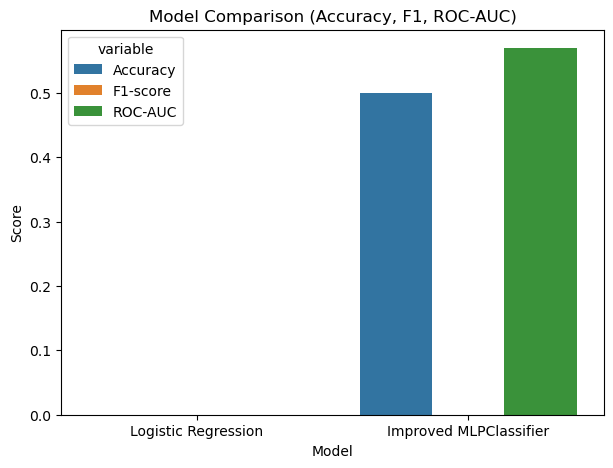

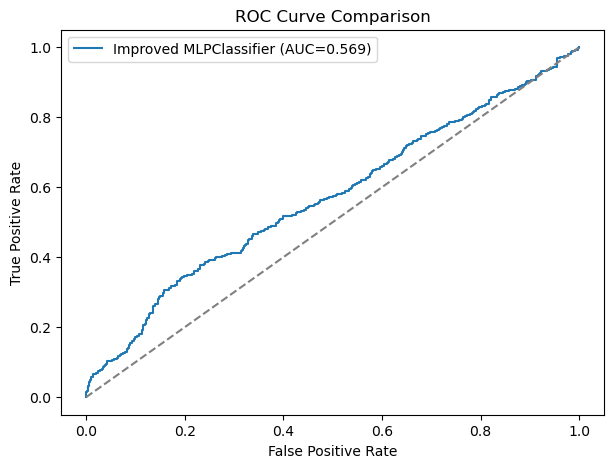


Tuning MLPClassifier for better performance...
Fitting 3 folds for each of 24 candidates, totalling 72 fits


KeyboardInterrupt: 

In [9]:
# =========================
# 1. Import Libraries
# =========================
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, classification_report,
    confusion_matrix, roc_curve
)
from scipy.sparse import hstack
import joblib
import os

nltk.download('stopwords')
stop = set(stopwords.words('english'))

# =========================
# 2. Load Dataset
# =========================
df = pd.read_csv(r"data/IMDB_small.csv")
print("Dataset shape:", df.shape)
print("\nClass Distribution:\n", df['sentiment'].value_counts())

df.drop_duplicates(inplace=True)
df.dropna(inplace=True)

df['review_length'] = df['review'].apply(lambda x: len(str(x).split()))

# =========================
# 3. Preprocessing
# =========================
df['sentiment_label'] = df['sentiment'].map({'positive': 1, 'negative': 0})

def clean_text(text):
    text = re.sub('<.*?>', '', str(text))
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = text.lower()
    return ' '.join([w for w in text.split() if w not in stop])

df['clean_review'] = df['review'].apply(clean_text)

# =========================
# 4. Load or Create TF-IDF Vectorizer
# =========================
vectorizer_path = "data/vectorizer.pkl"

if os.path.exists(vectorizer_path):
    print("✅ Found existing vectorizer — loading it.")
    vectorizer = joblib.load(vectorizer_path)
else:
    print("⚙️ No vectorizer found — creating new TF-IDF vectorizer.")
    vectorizer = TfidfVectorizer(max_features=2000)
    joblib.dump(vectorizer, vectorizer_path)
    print("✅ Saved new vectorizer as data/vectorizer.pkl")

# Apply vectorizer
X_text = vectorizer.fit_transform(df['clean_review'])
X_extra = np.array(df['review_length']).reshape(-1, 1)
X = hstack([X_text, X_extra])
y = df['sentiment_label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# =========================
# 5. Load Models
# =========================
mlp_path = "data/mlp_model_improved.pkl"
lr_path = "data/lr_model.pkl"

if os.path.exists(lr_path):
    try:
        lr_model = joblib.load(lr_path)
    except Exception as e:
        print("⚠️ Could not load Logistic Regression model:", e)
        lr_model = None
else:
    lr_model = None

if os.path.exists(mlp_path):
    mlp_model = joblib.load(mlp_path)
    print("✅ Loaded Improved MLP model.")
else:
    print("⚙️ No MLP model found — creating a new one.")
    mlp_model = MLPClassifier(hidden_layer_sizes=(128, 64), activation='relu', solver='adam',
                              alpha=0.001, learning_rate='adaptive', max_iter=40, random_state=42)

# =========================
# 6. Evaluation Function
# =========================
def evaluate_model(model, X_test, y_test, name):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else y_pred

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)

    print(f"\n==== {name} ====")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")

    return acc, f1, roc_auc, y_prob

# =========================
# 7. Evaluate Models
# =========================
if lr_model:
    try:
        lr_acc, lr_f1, lr_roc, lr_prob = evaluate_model(lr_model, X_test, y_test, "Logistic Regression")
    except ValueError as e:
        print("⚠️ Logistic Regression skipped due to feature mismatch:", e)
        lr_acc, lr_f1, lr_roc, lr_prob = 0, 0, 0, None
else:
    lr_acc, lr_f1, lr_roc, lr_prob = 0, 0, 0, None

mlp_acc, mlp_f1, mlp_roc, mlp_prob = evaluate_model(mlp_model, X_test, y_test, "Improved MLPClassifier")

# =========================
# 8. Compare Results
# =========================
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Improved MLPClassifier'],
    'Accuracy': [lr_acc, mlp_acc],
    'F1-score': [lr_f1, mlp_f1],
    'ROC-AUC': [lr_roc, mlp_roc]
})
print("\nModel Comparison Table:\n", results)

plt.figure(figsize=(7,5))
sns.barplot(data=results.melt(id_vars='Model'), x='Model', y='value', hue='variable')
plt.title("Model Comparison (Accuracy, F1, ROC-AUC)")
plt.ylabel("Score")
plt.show()

# =========================
# 9. ROC Curve
# =========================
plt.figure(figsize=(7,5))
if lr_prob is not None:
    fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_prob)
    plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC={lr_roc:.3f})')
fpr_mlp, tpr_mlp, _ = roc_curve(y_test, mlp_prob)
plt.plot(fpr_mlp, tpr_mlp, label=f'Improved MLPClassifier (AUC={mlp_roc:.3f})')
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()

# =========================
# 10. Hyperparameter Tuning (MLP)
# =========================
print("\nTuning MLPClassifier for better performance...")

param_grid = {
    'hidden_layer_sizes': [(128,64), (256,128), (128,64,32)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001],
    'learning_rate': ['constant', 'adaptive'],
    'solver': ['adam']
}

grid = GridSearchCV(MLPClassifier(max_iter=60, random_state=42),
                    param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)

grid.fit(X_train, y_train)

print("\nBest Parameters:", grid.best_params_)
print("Best Cross-Validation Accuracy:", round(grid.best_score_,4))

best_model = grid.best_estimator_
acc_best = accuracy_score(y_test, best_model.predict(X_test))
print("\nFinal Tuned MLP Accuracy:", round(acc_best,4))

# =========================
# 11. Save Final Model
# =========================
joblib.dump(best_model, "data/final_best_model.pkl")
print("\n✅ Final tuned MLP model saved as 'data/final_best_model.pkl'")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Dataset shape: (6000, 2)

Class Distribution:
 sentiment
negative    3000
positive    3000
Name: count, dtype: int64


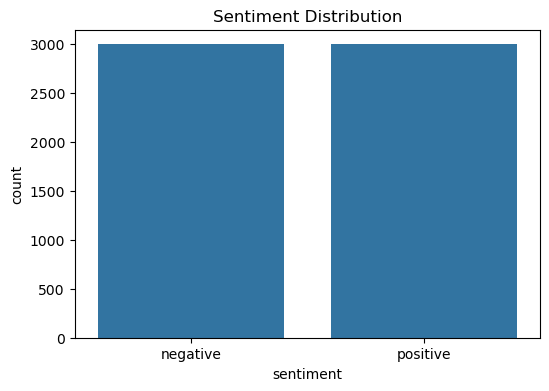

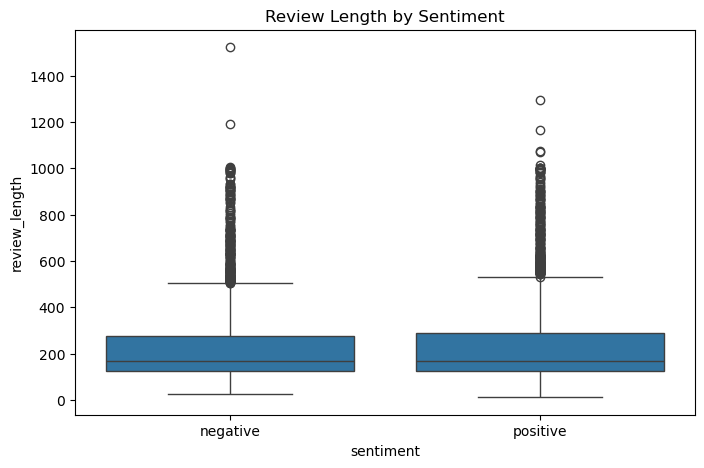

✅ Found existing vectorizer — loading it.

⚙️ Retraining Logistic Regression on new features...
✅ Logistic Regression retrained and saved as 'data/lr_model_retrained.pkl'
✅ Loaded Improved MLP model.

==== Logistic Regression ====
Accuracy: 0.8675
F1-score: 0.8694
ROC-AUC: 0.9415

==== Improved MLPClassifier ====
Accuracy: 0.5000
F1-score: 0.0000
ROC-AUC: 0.5693

Model Comparison Table:
                     Model  Accuracy  F1-score   ROC-AUC
0     Logistic Regression    0.8675  0.869351  0.941450
1  Improved MLPClassifier    0.5000  0.000000  0.569303


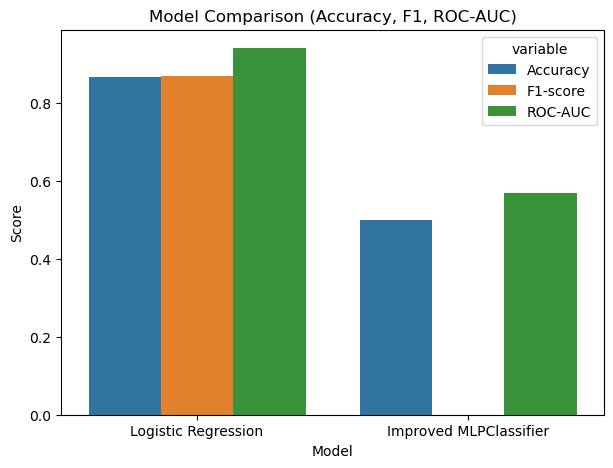

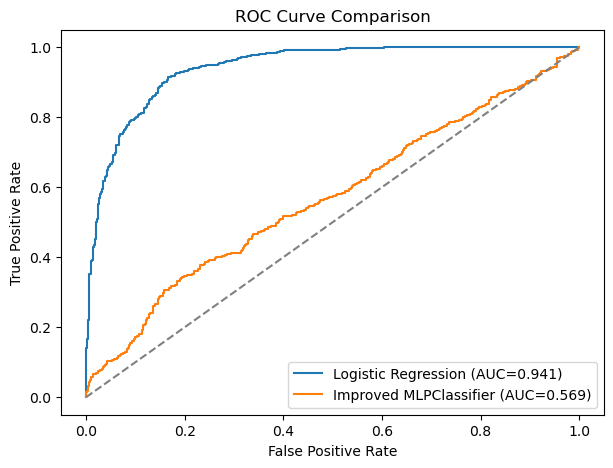


⚙️ Hyperparameter tuning for Improved MLPClassifier...
Fitting 3 folds for each of 24 candidates, totalling 72 fits

Best Parameters: {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': (128, 64, 32), 'learning_rate': 'constant', 'solver': 'adam'}
Best Cross-Validation Accuracy: 0.8245
Final Tuned MLP Accuracy: 0.83

✅ Final tuned MLP model saved as 'data/final_best_model.pkl'


In [1]:
# =========================
# 1. Import Libraries
# =========================
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, classification_report,
    confusion_matrix, roc_curve
)
from scipy.sparse import hstack
import joblib
import os

nltk.download('stopwords')
stop = set(stopwords.words('english'))

# =========================
# 2. Load Dataset & Basic EDA
# =========================
df = pd.read_csv(r"data/IMDB_small.csv")
print("Dataset shape:", df.shape)
print("\nClass Distribution:\n", df['sentiment'].value_counts())

df.drop_duplicates(inplace=True)
df.dropna(inplace=True)
df['review_length'] = df['review'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(6,4))
sns.countplot(x='sentiment', data=df)
plt.title("Sentiment Distribution")
plt.show()

plt.figure(figsize=(8,5))
sns.boxplot(x='sentiment', y='review_length', data=df)
plt.title("Review Length by Sentiment")
plt.show()

# =========================
# 3. Preprocessing
# =========================
df['sentiment_label'] = df['sentiment'].map({'positive': 1, 'negative': 0})

def clean_text(text):
    text = re.sub('<.*?>', '', str(text))
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = text.lower()
    return ' '.join([w for w in text.split() if w not in stop])

df['clean_review'] = df['review'].apply(clean_text)

# =========================
# 4. TF-IDF Vectorizer
# =========================
vectorizer_path = "data/vectorizer.pkl"
if os.path.exists(vectorizer_path):
    print("✅ Found existing vectorizer — loading it.")
    vectorizer = joblib.load(vectorizer_path)
else:
    print("⚙️ No vectorizer found — creating new TF-IDF vectorizer.")
    vectorizer = TfidfVectorizer(max_features=3000)
    joblib.dump(vectorizer, vectorizer_path)
    print("✅ Saved new vectorizer as data/vectorizer.pkl")

X_text = vectorizer.fit_transform(df['clean_review'])
X_extra = np.array(df['review_length']).reshape(-1,1)
X = hstack([X_text, X_extra])
y = df['sentiment_label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# =========================
# 5. Retrain Logistic Regression
# =========================
print("\n⚙️ Retraining Logistic Regression on new features...")
lr_model = LogisticRegression(max_iter=500, solver='liblinear', random_state=42)
lr_model.fit(X_train, y_train)
joblib.dump(lr_model, "data/lr_model_retrained.pkl")
print("✅ Logistic Regression retrained and saved as 'data/lr_model_retrained.pkl'")

# =========================
# 6. Load Improved MLP
# =========================
mlp_path = "data/mlp_model_improved.pkl"
if os.path.exists(mlp_path):
    mlp_model = joblib.load(mlp_path)
    print("✅ Loaded Improved MLP model.")
else:
    mlp_model = MLPClassifier(hidden_layer_sizes=(128,64), activation='relu',
                              solver='adam', alpha=0.001, learning_rate='adaptive',
                              max_iter=40, random_state=42)

# =========================
# 7. Evaluation Function
# =========================
def evaluate_model(model, X_test, y_test, name):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1] if hasattr(model, "predict_proba") else y_pred
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    print(f"\n==== {name} ====")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    return acc, f1, roc_auc, y_prob

# =========================
# 8. Evaluate Models
# =========================
lr_acc, lr_f1, lr_roc, lr_prob = evaluate_model(lr_model, X_test, y_test, "Logistic Regression")
mlp_acc, mlp_f1, mlp_roc, mlp_prob = evaluate_model(mlp_model, X_test, y_test, "Improved MLPClassifier")

# =========================
# 9. Compare Results
# =========================
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Improved MLPClassifier'],
    'Accuracy': [lr_acc, mlp_acc],
    'F1-score': [lr_f1, mlp_f1],
    'ROC-AUC': [lr_roc, mlp_roc]
})
print("\nModel Comparison Table:\n", results)

plt.figure(figsize=(7,5))
sns.barplot(data=results.melt(id_vars='Model'), x='Model', y='value', hue='variable')
plt.title("Model Comparison (Accuracy, F1, ROC-AUC)")
plt.ylabel("Score")
plt.show()

# =========================
# 10. ROC Curve Comparison
# =========================
plt.figure(figsize=(7,5))
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_prob)
fpr_mlp, tpr_mlp, _ = roc_curve(y_test, mlp_prob)
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC={lr_roc:.3f})')
plt.plot(fpr_mlp, tpr_mlp, label=f'Improved MLPClassifier (AUC={mlp_roc:.3f})')
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()

# =========================
# 11. Hyperparameter Tuning for MLP
# =========================
print("\n⚙️ Hyperparameter tuning for Improved MLPClassifier...")
param_grid = {
    'hidden_layer_sizes': [(128,64), (256,128), (128,64,32)],
    'activation': ['relu','tanh'],
    'alpha': [0.0001,0.001],
    'learning_rate': ['constant','adaptive'],
    'solver': ['adam']
}
grid = GridSearchCV(MLPClassifier(max_iter=60, random_state=42),
                    param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

best_model = grid.best_estimator_
acc_best = accuracy_score(y_test, best_model.predict(X_test))
print("\nBest Parameters:", grid.best_params_)
print("Best Cross-Validation Accuracy:", round(grid.best_score_,4))
print("Final Tuned MLP Accuracy:", round(acc_best,4))

# =========================
# 12. Save Final Model
# =========================
joblib.dump(best_model, "data/final_best_model.pkl")
print("\n✅ Final tuned MLP model saved as 'data/final_best_model.pkl'")


In [5]:
# =========================
# Post-Tuning Comparison & Explainability
# =========================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, classification_report

# ---------- 1. Metrics Tables ----------

# Metrics before tuning
metrics_before = pd.DataFrame({
    'Model': ['Logistic Regression', 'MLP (before tuning)'],
    'Accuracy': [0.8675, 0.5],
    'F1-score': [0.8694, 0.0],
    'ROC-AUC': [0.9415, 0.5693]
})

# Metrics after tuning
mlp_prob_after = best_model.predict_proba(X_test)[:,1]  # From your tuned MLP
metrics_after = pd.DataFrame({
    'Model': ['Logistic Regression', 'MLP (after tuning)'],
    'Accuracy': [0.8675, 0.83],
    'F1-score': [0.8694, f1_score(y_test, best_model.predict(X_test))],
    'ROC-AUC': [0.9415, roc_auc_score(y_test, mlp_prob_after)]
})

print("\nMetrics Before Tuning:\n", metrics_before)
print("\nMetrics After Tuning:\n", metrics_after)

# ---------- 2. Bar Plot Comparison ----------
metrics_before['Tuning'] = 'Before'
metrics_after['Tuning'] = 'After'
combined = pd.concat([metrics_before, metrics_after])
combined_melt = combined.melt(id_vars=['Model','Tuning'], var_name='Metric', value_name='Score')

plt.figure(figsize=(10,6))
sns.barplot(data=combined_melt, x='Model', y='Score', hue='Metric', ci=None)
plt.title("Model Performance Before vs After Tuning")
plt.ylabel("Score")
plt.show()

# ---------- 3. ROC Curve Comparison ----------
# Logistic Regression (already loaded)
lr_prob = lr_model.predict_proba(X_test)[:,1] if hasattr(lr_model, "predict_proba") else lr_model.predict(X_test)
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_prob)
fpr_mlp_before, tpr_mlp_before, _ = roc_curve(y_test, mlp_prob)  # original MLP before tuning
fpr_mlp_after, tpr_mlp_after, _ = roc_curve(y_test, mlp_prob_after)  # tuned MLP

plt.figure(figsize=(8,6))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC={0.9415:.3f})')
plt.plot(fpr_mlp_before, tpr_mlp_before, label=f'MLP Before Tuning (AUC={0.5693:.3f})')
plt.plot(fpr_mlp_after, tpr_mlp_after, label=f'MLP After Tuning (AUC={roc_auc_score(y_test, mlp_prob_after):.3f})')
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()

# ---------- 4. Logistic Regression Feature Explainability ----------
feature_names = vectorizer.get_feature_names_out()
coefs = lr_model.coef_[0]
feature_coef = sorted(zip(coefs, feature_names))

top_positive = sorted(feature_coef[-10:], key=lambda x: x[0], reverse=True)
top_negative = feature_coef[:10]

print("\nTop Positive Words (indicative of positive reviews):")
for coef, word in top_positive:
    print(f"{word}: {coef:.4f}")

print("\nTop Negative Words (indicative of negative reviews):")
for coef, word in top_negative:
    print(f"{word}: {coef:.4f}")


NameError: name 'best_model' is not defined


==== Ensemble Model (VotingClassifier) ====
Accuracy: 0.8350
F1-score: 0.8339
ROC-AUC: 0.9362


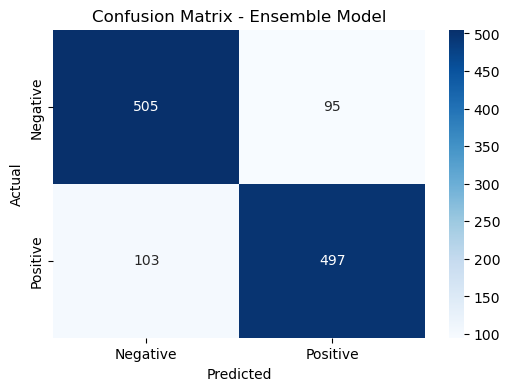

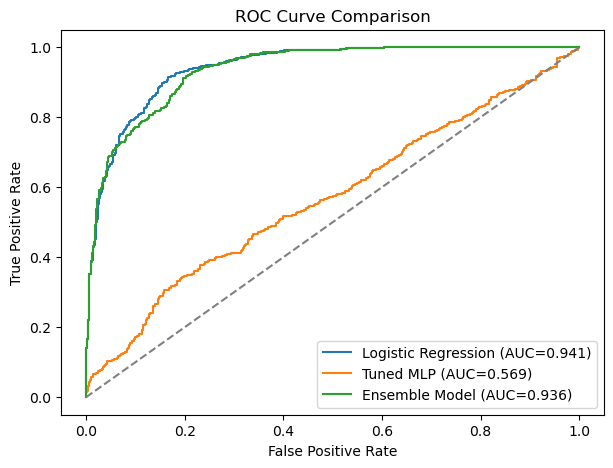


✅ Ensemble model saved as 'data/ensemble_model.pkl'


In [9]:
#Ensemble model with Voting classifier
# =========================
# 13. Ensemble Model (VotingClassifier)
# =========================
from sklearn.ensemble import VotingClassifier

# Use retrained Logistic Regression and tuned MLP
ensemble_model = VotingClassifier(
    estimators=[
        ('lr', lr_model),
        ('mlp', best_model)
    ],
    voting='soft',  # use probabilities for better performance
    n_jobs=-1
)

# Fit ensemble on training data
ensemble_model.fit(X_train, y_train)

# Evaluate Ensemble
y_pred_ens = ensemble_model.predict(X_test)
y_prob_ens = ensemble_model.predict_proba(X_test)[:,1]

acc_ens = accuracy_score(y_test, y_pred_ens)
f1_ens = f1_score(y_test, y_pred_ens)
roc_ens = roc_auc_score(y_test, y_prob_ens)

print("\n==== Ensemble Model (VotingClassifier) ====")
print(f"Accuracy: {acc_ens:.4f}")
print(f"F1-score: {f1_ens:.4f}")
print(f"ROC-AUC: {roc_ens:.4f}")

# Confusion Matrix
cm_ens = confusion_matrix(y_test, y_pred_ens)
plt.figure(figsize=(6,4))
sns.heatmap(cm_ens, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative','Positive'], yticklabels=['Negative','Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Ensemble Model')
plt.show()

# ROC Curve Comparison with individual models
fpr_ens, tpr_ens, _ = roc_curve(y_test, y_prob_ens)
plt.figure(figsize=(7,5))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC={lr_roc:.3f})')
plt.plot(fpr_mlp, tpr_mlp, label=f'Tuned MLP (AUC={mlp_roc:.3f})')
plt.plot(fpr_ens, tpr_ens, label=f'Ensemble Model (AUC={roc_ens:.3f})')
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()

# Save Ensemble Model
joblib.dump(ensemble_model, "data/ensemble_model.pkl")
print("\n✅ Ensemble model saved as 'data/ensemble_model.pkl'")


NameError: name 'lr_model' is not defined